## Introduction

In this example, we adapted the implementation [Enhanced Deep Residual Networks for Single Image Super-Resolution (EDSR) implementation of Gitesh Chawda](https://github.com/keras-team/keras-io/blob/master/examples/vision/edsr.py)

The EDSR architecture is based on the SRResNet architecture and consists of multiple
residual blocks. It uses constant scaling layers instead of batch normalization layers to
produce consistent results. 

Our implementation used 32 residual blocks and 64 feature channels.

Super-resolution Papers:
[A comprehensive review of deep learning based single image super-resolution](https://arxiv.org/abs/2102.09351)
[A comprehensive review of deep learning based single image super-resolution](https://arxiv.org/abs/2102.09351)
[A comprehensive review of deep learning based single image super-resolution](https://arxiv.org/abs/2102.09351)


## Imports

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
import tifffile

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

AUTOTUNE = tf.data.AUTOTUNE

# Change scale for different super-resolution factors
scale = 2
#  CHange depth for different number of residual blocks
depth = 32

Import images from foulders

In [ ]:
def import_images(folder_path):
    files_in_folder = sorted(os.listdir(folder_path))
    images = [file for file in files_in_folder if os.path.isfile(os.path.join(folder_path, file))]
    image_objects = []
    for image_name in images:
        full_path = os.path.join(folder_path, image_name)
        image = np.array(tifffile.imread(full_path))

        image_objects.append(image)
    image_objects = np.array(image_objects)

    return image_objects

In [ ]:
lr_train_path = "dataset/train/lr/"
hr_train_path = "dataset/train/hr/"
lr_val_path = "dataset/val/lr/"
hr_val_path = "dataset/val/hr/"

lr_train = import_images(lr_train_path)
hr_train = import_images(hr_train_path)
lr_val = import_images(lr_val_path)
hr_val = import_images(hr_val_path)

In [ ]:
# As pixels in MudrockZoom images are between 0-254 (from aquisition), downsampled images needs to be normalized 

min_val = 0
max_val = 254

downsampled_train_paste = 'dadownsampled/train/'
downsampled_lr_train = import_images(downsampled_train_paste)

downsampled_val_paste = 'dadownsampled/val/'
downsampled_lr_val = import_images(downsampled_val_paste)

downsampled_lr_train = cv2.normalize(downsampled_lr_train, None, min_val, max_val, cv2.NORM_MINMAX, dtype=cv2.CV_8U)
downsampled_lr_val = cv2.normalize(downsampled_lr_val, None, min_val, max_val, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

print("downsampled_lr_train.shape:", downsampled_lr_train.shape)
print("downsampled_lr_val.shape:", downsampled_lr_val.shape)

lr_train.shape: (134, 384, 512)
lr_test.shape: (16, 384, 512)
lr_val.shape: (16, 384, 512)


In [ ]:
lr_train_dim = np.expand_dims(lr_train, axis=-1)
hr_train_dim = np.expand_dims(hr_train, axis=-1)
lr_val_dim = np.expand_dims(lr_val, axis=-1)
hr_val_dim = np.expand_dims(hr_val, axis=-1)

In [ ]:
lr_train_tensor = tf.convert_to_tensor(lr_train_dim, dtype=tf.uint8)
lr_val_tensor = tf.convert_to_tensor(lr_val_dim, dtype=tf.uint8)
hr_train_tensor = tf.convert_to_tensor(hr_train_dim, dtype=tf.uint8)
hr_val_tensor = tf.convert_to_tensor(hr_val_dim, dtype=tf.uint8)

train_ds = tf.data.Dataset.from_tensor_slices((lr_train_tensor, hr_train_tensor))
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
train_ds_cache = train_ds.cache()

valid_ds = tf.data.Dataset.from_tensor_slices((lr_val_tensor, hr_val_tensor))
valid_ds = valid_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
valid_ds_cache = valid_ds.cache()

2024-06-13 15:35:55.600389: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11361 MB memory:  -> device: 0, name: NVIDIA GeForce GTX TITAN X, pci bus id: 0000:02:00.0, compute capability: 5.2


Visualização do Conjunto de Treinamento:


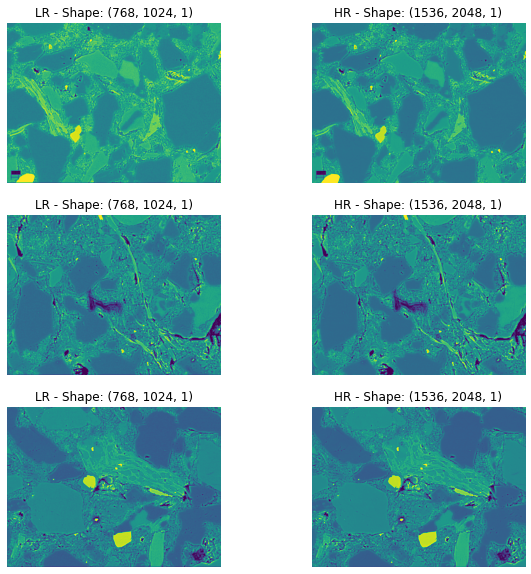


Visualização do Conjunto de Validação:


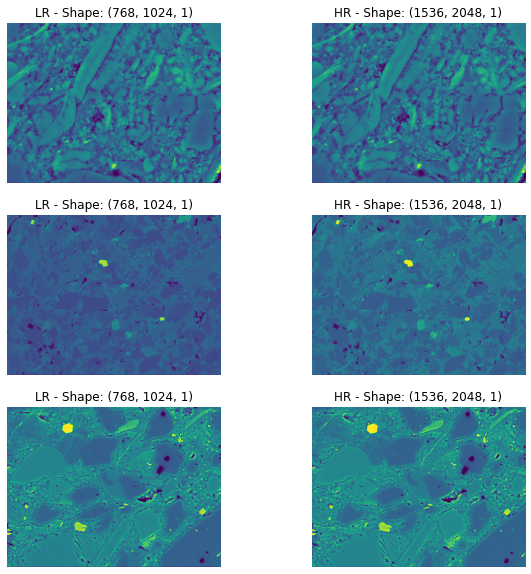

In [ ]:
# Function to display images from the dataset
def display_images(dataset, num_images=3):
    plt.figure(figsize=(10, 10))
    dataset_iter = iter(dataset)

    for i in range(num_images):
        lr, hr = next(dataset_iter)

        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(lr.numpy().astype("uint8"))
        plt.title("LR - Shape: {}".format(lr.shape))
        plt.axis("off")

        plt.subplot(num_images, 2, 2*i + 2)
        plt.imshow(hr.numpy().astype("uint8"))
        plt.title("HR - Shape: {}".format(hr.shape))
        plt.axis("off")

    plt.show()

print("Train data:")
display_images(train_ds)
print("\nValidation data:")
display_images(valid_ds)


## Augmentation

Only geometric augmentation: rotation, flipping and cropping

In [ ]:
def flip_left_right(lowres_img, highres_img):
    """Flips Images to left and right."""

    rn = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(
        rn < 0.5,
        lambda: (lowres_img, highres_img),
        lambda: (
            tf.image.flip_left_right(lowres_img),
            tf.image.flip_left_right(highres_img),
        ),
    )


def random_rotate(lowres_img, highres_img):
    """Rotates Images by 90 degrees."""

    rn = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
    return tf.image.rot90(lowres_img, rn), tf.image.rot90(highres_img, rn)


def random_crop(lowres_img, highres_img, hr_crop_size=320, scale=scale):
    """Crop images.

    low resolution images: calculates considering scale factor
    high resolution images: parameter hr_crop_size or settled manually (default value = 320)
    """
    lowres_crop_size = hr_crop_size // scale  
    lowres_img_shape = tf.shape(lowres_img)[:2]  

    lowres_width = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[1] - lowres_crop_size + 1, dtype=tf.int32
    )
    lowres_height = tf.random.uniform(
        shape=(), maxval=lowres_img_shape[0] - lowres_crop_size + 1, dtype=tf.int32
    )

    highres_width = lowres_width * scale
    highres_height = lowres_height * scale

    lowres_img_cropped = lowres_img[
        lowres_height : lowres_height + lowres_crop_size,
        lowres_width : lowres_width + lowres_crop_size,
    ]  
    highres_img_cropped = highres_img[
        highres_height : highres_height + hr_crop_size,
        highres_width : highres_width + hr_crop_size,
    ] 

    return lowres_img_cropped, highres_img_cropped


## Prepare a `tf.data.Dataset` object

We augment on-the-fly the training data with random horizontal flips and 90 rotations, while validation is only randomly cropped.

You can settle train and val batch sizes 

In [ ]:
def dataset_object(dataset, training=True):

    ds = dataset
    ds = ds.map(
        lambda lowres, highres: random_crop(lowres, highres, scale=2),
        num_parallel_calls=AUTOTUNE,
    )

    if training:
        ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
        ds = ds.map(flip_left_right, num_parallel_calls=AUTOTUNE)
    # Batching Data
    if training:
        ds = ds.batch(16)
    else:
        ds = ds.batch(16)

    if training:
        ds = ds.repeat()
    ds = ds.prefetch(buffer_size=AUTOTUNE)
    de = ds.cache
    return ds


train_ds = dataset_object(train_ds_cache, training=True)
val_ds = dataset_object(valid_ds_cache, training=False)

## Visualize the data

Let's visualize a few sample images:

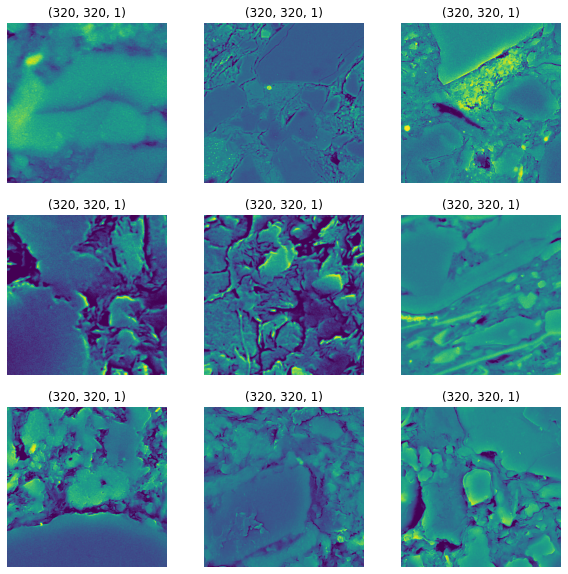

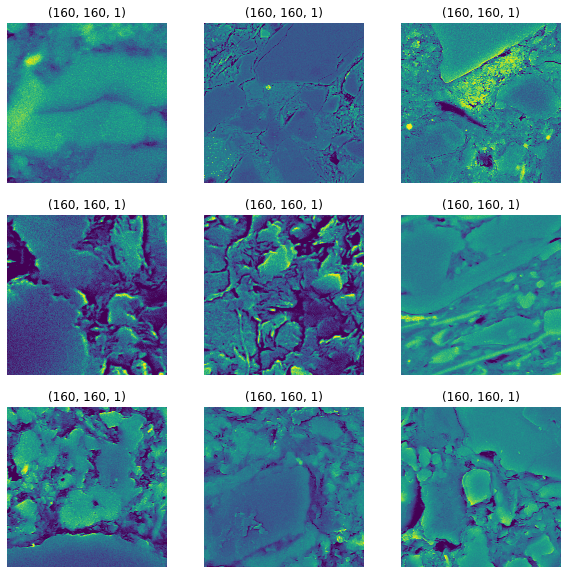

In [ ]:
lowres, highres = next(iter(val_ds))

# High Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(highres[i].numpy().astype("uint8"))
    plt.title(highres[i].shape)
    plt.axis("off")

# Low Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lowres[i].numpy().astype("uint8"))
    plt.title(lowres[i].shape)
    plt.axis("off")


def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=254)[0]

    return psnr_value


## Build the model

### Comparison with model with three residual blocks

The residual block design of EDSR differs from that of ResNet. Batch normalization
layers have been removed (together with the final ReLU activation): since batch normalization
layers normalize the features, they hurt output value range flexibility.
It is thus better to remove them. Further, it also helps reduce the
amount of GPU RAM required by the model, since the batch normalization layers consume the same amount of
memory as the preceding convolutional layers.

<img src="https://miro.medium.com/max/1050/1*EPviXGqlGWotVtV2gqVvNg.png" width="500" />

In [ ]:
class EDSRModel(tf.keras.Model):
    def train_step(self, data):
        x, y = data

        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, x):
        x = tf.cast(tf.expand_dims(x, axis=0), tf.float32)
        super_resolution_img = self(x, training=False)
        super_resolution_img = tf.clip_by_value(super_resolution_img, 0, 255)
        super_resolution_img = tf.round(super_resolution_img)
        super_resolution_img = tf.squeeze(
            tf.cast(super_resolution_img, tf.uint8), axis=0
        )
        return super_resolution_img


def ResBlock(inputs):
    x = layers.Conv2D(64, 3, padding="same", activation="relu")(inputs)
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.Add()([inputs, x])
    return x


def Upsampling(inputs, factor=2, **kwargs):
    x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(inputs)
    x = tf.nn.depth_to_space(x, block_size=factor)

    # for 4x upsacaling, add these layers
    #x = layers.Conv2D(64 * (factor ** 2), 3, padding="same", **kwargs)(x)  
    #x = tf.nn.depth_to_space(x, block_size=factor)
    return x


def make_model(num_filters, num_of_residual_blocks):
    input_layer = layers.Input(shape=(None, None, 1))
    x = layers.Rescaling(scale=1.0 / 255)(input_layer)
    x = x_new = layers.Conv2D(num_filters, 3, padding="same")(x)

    for _ in range(num_of_residual_blocks):
        x_new = ResBlock(x_new)

    x_new = layers.Conv2D(num_filters, 3, padding="same")(x_new)
    x = layers.Add()([x, x_new])

    x = Upsampling(x)
    x = layers.Conv2D(1, 3, padding="same")(x)

    output_layer = layers.Rescaling(scale=255)(x)
    return EDSRModel(input_layer, output_layer)


model = make_model(num_filters=64, num_of_residual_blocks=depth)

In [ ]:
model.load_weights('models/real.h5')

## Train the model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_dir = f"training_ckpt/{scale}_{depth}/"
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

checkpoint_path = os.path.join(checkpoint_dir,f"cp-{{epoch:03d}}.ckpt")
checkpoint_callback = ModelCheckpoint(filepath=checkpoint_path,
                                      save_weights_only=True,
                                      verbose=1,
                                      save_freq=100000)  # Save every 100000 samples seen

In [ ]:
# Using adam optimizer with initial learning rate as 1e-4, changing learning rate after 200000 steps to 5e-5
optim_edsr = keras.optimizers.Adam(
    learning_rate=keras.optimizers.schedules.PiecewiseConstantDecay(
        boundaries=[200000], values=[1e-4,5e-5]))
model.compile(optimizer=optim_edsr, loss="mean_absolute_error", metrics=[PSNR])
epochs = 600

history = model.fit(train_ds, epochs=epochs, steps_per_epoch=1000, validation_data=val_ds, callbacks=[checkpoint_callback])

Epoch 1/100


2024-06-13 15:39:34.907564: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8902
2024-06-13 15:39:47.641162: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-13 15:39:47.641224: W tensorflow/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.53GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-13 15:39:51.317184: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x153518781b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-06-13 15:39:51.317224: I tensorflow/compiler/xla/service/service.cc:176]   Str

1000/1000 [==============================] - 1207s 1s/step - loss: 14.8011 - PSNR: 21.6924 - val_loss: 16.3477 - val_PSNR: 28.5666
Epoch 2/100
1000/1000 [==============================] - 1170s 1s/step - loss: 14.6319 - PSNR: 21.7397 - val_loss: 15.7968 - val_PSNR: 29.3976
Epoch 3/100
1000/1000 [==============================] - 1169s 1s/step - loss: 14.5338 - PSNR: 21.7940 - val_loss: 14.0728 - val_PSNR: 28.6425
Epoch 4/100
1000/1000 [==============================] - 1169s 1s/step - loss: 14.4269 - PSNR: 22.0127 - val_loss: 16.3275 - val_PSNR: 27.9848
Epoch 5/100
1000/1000 [==============================] - 1169s 1s/step - loss: 14.3556 - PSNR: 22.1260 - val_loss: 15.1562 - val_PSNR: 27.1397
Epoch 6/100
1000/1000 [==============================] - 1169s 1s/step - loss: 14.1855 - PSNR: 22.1708 - val_loss: 16.0937 - val_PSNR: 28.3601
Epoch 7/100
1000/1000 [==============================] - 1169s 1s/step - loss: 14.0996 - PSNR: 22.2711 - val_loss: 17.5593 - val_PSNR: 29.2306
Epoch 8/100

In [ ]:
loss = history.history['loss']
psnr = history.history['PSNR']
val_loss = history.history['val_loss']
val_psnr = history.history['val_PSNR']

epochs = np.arange(1, epochs+1) 

plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, psnr, label='Training PSNR')
plt.plot(epochs, val_psnr, label='Validation PSNR')
plt.title('Training and Validation PSNR')
plt.xlabel('Epochs')
plt.ylabel('PSNR')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
model.save_weights('modelos/yourModel.h5')

## Final remarks

In this example, we implemented the EDSR model (Enhanced Deep Residual Networks for Single Image
Super-Resolution). You can try with other architectures or datasets. Using, or not, MudrockZoom.